In [1]:
import qiskit
qiskit.__qiskit_version__
from qiskit.visualization import plot_histogram
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.optimize as optimize

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
#from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.quantum_info import Pauli
#from qiskit.aqua.operators import op_converter
#from qiskit.aqua.operators import WeightedPauliOperator
import qiskit 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from time import time

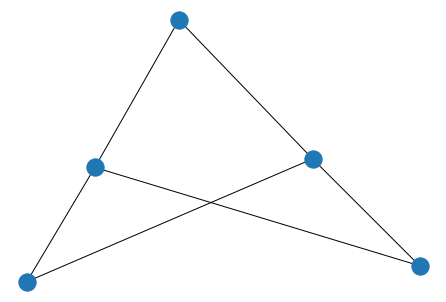

In [3]:
def butterfly():
    '''Generating the butterfly graph with 5 nodes'''
    n     = 5
    V     = np.arange(0,n,1)
    E     =[(0,3,1.0),(0,4,1.0),(1,3,1.0),(1,4,1.0),(2,3,1.0),(2,4,1.0)] 
    
    G     = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    return G





#G = nx.Graph()
#G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
#nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))
#backend = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('qasm_simulator')



def diamond():
    '''
    Creates a diamond graph, i.e. a graph with 4 nodes and 5 edges 
    Also see https://www.graphclasses.org/smallgraphs.html#nodes4
    '''
    n = 5 # Number of nodes in graph
    G = nx.Graph()
    G.add_nodes_from(np.arange(0,n,1))
    elist = [(0,3,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),()]
    # tuple is (i,j,weight) where (i,j) is the edge
    G.add_weighted_edges_from(elist)
    
    return G

G=butterfly()
nx.draw(G)

In [4]:
def objective(G, x):
    '''Calculating the value of a cut x on graph G, 
    where x is represented by a numpy array of 1s and 0s
    '''
    w = nx.to_numpy_array(G)
    spin = pow(-1,x) # bijection from 0,1 to 1,-1
    
    return 0.5*sum([w[i,j]*(1-spin[i]*spin[j]) for i,j in G.edges]) 

def create_circuit(G, gamma, beta):
    '''Creating QAOA circuit for given angles'''
    # Setting p (and checking if beta and gamma are of the same size)
    #print(len(beta))
    if len(beta) == len(gamma):
        p = len(beta)
    else:
        raise ValueError("The parameter array beta must have the same length as parameter gamma")
    
    n = len(G)
    circ = qiskit.QuantumCircuit(n)
    
    for i in range(n):
        circ.h(i)
        
    for i in range(p):
        for a,b in G.edges:
            circ.cx(a,b)
            circ.rz(-gamma[i],b) #PLUS or MINUS! Does it matter? We optimize anyway - it does affect the range of gamma and the patterns
            circ.cx(a,b)
        circ.barrier()
        for a in G.nodes:
            circ.rx(beta[i], a)
    
    circ.measure_all()
    
    return circ

def expectation(G, gamma, beta, backend, n_samples = 1024):
    '''Evaluates expectation for given graph and angles'''
    
    # create circuit and run it n_shots times
    counts = sample(G, gamma, beta, backend, n_samples = n_samples)
    
    def bitstring_to_array(x):
        return np.array([int(d) for d in str(x)])
    
    avg = sum([counts[x] * objective(G,bitstring_to_array(x)) for x in counts])/n_samples
    
    return avg

def find_local_angles(G, gamma, beta, backend, n_samples = 1024, optimizer = 'COBYLA', optimizer_options = None):
    '''Find local optimum beginning from gamma, beta (these are overwritten)
    Note that (gamma,beta) is the initial point and are overwritten when this method is run
    '''    

    def fun(angles):
        ''' The objective function to be optimised by varying the angles
        Note, we want to maximize the expectation <Hc>, this is equivalent to 
        minimizing - <Hc>'''
        new_gamma = angles[:len(angles)//2]
        new_beta = angles[len(angles)//2:]
        
        # maximize f = minimize -f 
        return -expectation(G, new_gamma, new_beta, backend, n_samples) 
    
    x0 = gamma+beta
    result = scipy.optimize.minimize(fun, x0, method= optimizer,options={'maxiter':2500})
    
    # finding angles
    angles = result.x
    new_gamma = angles[:len(angles)//2]
    new_beta = angles[len(angles)//2:]
    return result,new_gamma, new_beta
  

    
def sample(G, gamma, beta, backend, n_samples = 1024, plot_histogram = False):
    circ = create_circuit(G,beta,gamma)
    #backend = Aer.get_backend(’qasm_simulator’, basis_gates=basis_gates,noise_model=noise_model)
    result = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), shots = n_samples).result()
    counts = result.get_counts()
    counts=invert_counts(counts)
    if plot_histogram:
        from qiskit.tools.visualization import plot_histogram
        plot_histogram(counts)
        
    return counts

def get_angles_INTERP(G, p, backend, initial_gamma = [1.2], initial_beta = [2]):
    '''
    Finds quasi-optimal angles for a given graph G
    Iteratively increase p, using an interpolation-based strategy
    to find initial points for optimization
    '''
    
    def INTERP_next_angles(angles):
        '''Takes in a set of p angles and returns a new set of p+1 angles using the INTERP method'''
        
        assert len(gamma) == len(beta), "Both lists of parameters gamma, beta must be of the same length"
        
        p = len(angles)
        
        new_angles = [angles[0]] # i = 1, the first angles coincide
        for i in range(2, p+1):
            new_angles.append( (i-1)/p*angles[i-2] + (p-i+1)/p*angles[i-1]) # i in {2, ... , p}, interpolation 
        new_angles.append(angles[-1]) # i = p+1, the last angles coincide
            
        return new_angles

    # p = 1 (check this - in Zhou et al. gamma in [-pi/2,pi/2) for udR graphs and beta in [-pi/4, pi/4]]) in general
    
    # find first set of angles
    result,gamma,beta = find_local_angles(G,initial_gamma,initial_beta,backend)
    
    for i in range(p-1):
        gamma_ansatz,beta_ansatz = INTERP_next_angles(gamma), INTERP_next_angles(beta) # new initial points
        print("ansatz gamma, beta", gamma_ansatz, beta_ansatz)
        result,gamma,beta = find_local_angles(G,gamma_ansatz,beta_ansatz,backend) # new (local) optima  
        print("RESULT :",result)
        print("local optima",result, gamma, beta)
    
    return result,gamma, beta

def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [14]:
t0=time()
result,optimal_gamma,optimal_beta=get_angles_INTERP(G, 4, backend, initial_gamma = [0.], initial_beta = [1.])
S = sample(G, optimal_gamma,optimal_beta, backend, n_samples = 1024, plot_histogram=True)
time()-t0

ansatz gamma, beta [0.9524338052186967, 0.9524338052186967] [0.7469811342103264, 0.7469811342103264]
RESULT :      fun: -5.4755859375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 47
  status: 1
 success: True
       x: array([1.18547252, 0.87676403, 0.712981  , 0.84292484])
local optima      fun: -5.4755859375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 47
  status: 1
 success: True
       x: array([1.18547252, 0.87676403, 0.712981  , 0.84292484]) [1.18547252 0.87676403] [0.712981   0.84292484]
ansatz gamma, beta [1.185472516490918, 1.0311182718056013, 0.8767640271202846] [0.7129809975272352, 0.7779529194371486, 0.8429248413470619]
RESULT :      fun: -5.798828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 63
  status: 1
 success: True
       x: array([0.86874787, 0.98069128, 0.5119516 , 0.43833995, 0.71814093,
       0.71098568])
local optima      fun: -5.798828125
   maxcv: 0.0
 message: 'Optimiz

3.0199334621429443

In [15]:
print(optimal_gamma)

[0.71697867 0.65975284 0.50852127 0.40329573]


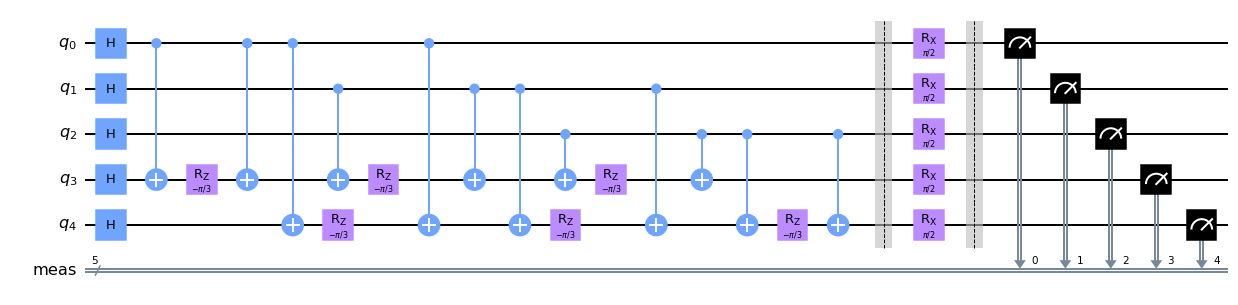

In [16]:
qc = create_circuit(G,[np.pi/3], [np.pi/2])
qc.draw(output='mpl')

In [17]:
S = sample(G, optimal_gamma,optimal_beta, backend, n_samples = 1024, plot_histogram=True)

In [18]:
print(S)

{'10000': 2, '01001': 1, '01101': 1, '00011': 484, '10011': 3, '01011': 8, '00111': 4, '10111': 4, '01111': 3, '11111': 3, '01000': 3, '11000': 7, '00100': 3, '10100': 9, '01100': 2, '11100': 487}


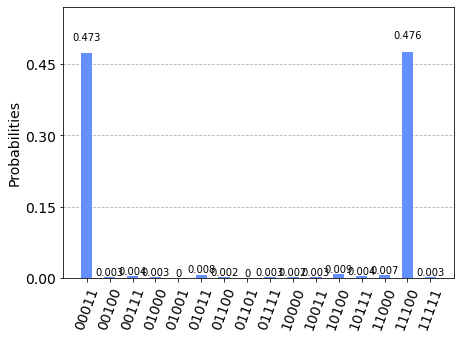

In [19]:
plot_histogram(S)

In [20]:
def bitstring_to_array(x):
        return np.array([int(d) for d in str(x)])

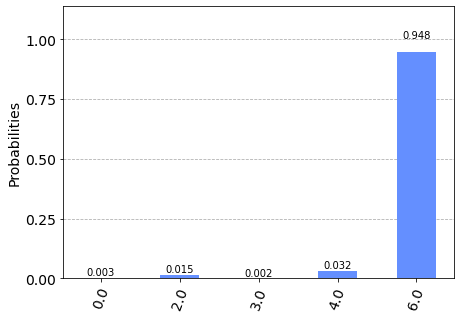

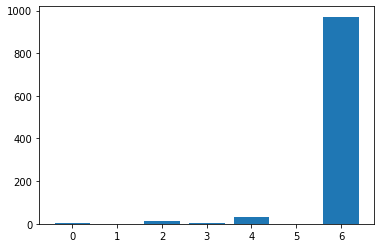

In [21]:
energies = defaultdict(int)
for k, v in S.items():
    z = bitstring_to_array(k)
    energies[objective(G,z)]+=v
x,y = zip(*energies.items())
plt.bar(x,y)



plot_histogram(energies)